<a id='top'></a>
## Two-dimensional Models - Advective Flow

[Simple Advective Flow using the Method of Lines](#saf_mol)

[Simple Advective Flow using a Full Grid Method](#saf_grid)

[Advective Flow with Biotic Uptake Term - Method of Lines](#safb_mol)

[Advective Flow with Biotic Uptake Term - Full Grid Method](#safb_grid)

[Advection/Reaction - Two State Variable System](#ar2_mol)

#### Before we get started, let's define some model parameters that will be used in all of the example below.

We do this as a convenience, so that the parameters are defined in a single spot.  This implies that if we want to change any of these parameters, we'll need to rerun all models in cells below.

In [1]:
import numpy as np

# geometry
length = 10              # length of the channel, m 
dx =  0.1               # length of a compartment/node, m
n = int(length/dx)       # number of compartments needed (method of lines only)
ncols = n+1              # number of columns (nodes) needed to solve (grid method only).  Note that we include
                         # one extra, representing the left-hand boundary condition
# time
endTime = 12             # length of simulation (days)
dt = 0.01                # time step (grid method only)
nrows = int(endTime/dt)  # number of grid rows for grid solution method 

# model parameters
flowrate = 1.0           # m/day (note this is a linear flow rate, not a volumetric flow rate)
mumax = 0.055            # maximum growth rate for biotic component (g/g/day)
Kc = 0.2                 # Monod half-velocity parameter (mg/l)
Ybc = 0.15               # yield coefficient, gB produced/gC consumed

# make arrays to hold distances and times for method lines and grid methods.  We'll use these for plotting results
distsMoL = np.arange(dx/2,length+dx/2, dx)  # place the distance in the *center* of the compartment
distsGrid = np.arange(0,length+dx/2, dx)    # place the grid node starting on the left-hand boundary

times = np.arange(0,endTime+dt/2, dt)
t = len(times)

print( "Parameters have been initialized!  {} compartments, {} nodes and {} time steps defined".format(n,ncols,t))

Parameters have been initialized!  100 compartments, 101 nodes and 1201 time steps defined


<hr><a id='saf_mol'></a><div style='text-align:right;width=100%'><a href='#top'>top</a></div>

## Simple Advective Flow with the Method of Lines

Our first model considers the dynamics of advective flow in one spatial dimension. The model is:

$\large \frac{dC}{dt} = -f \frac{dC}{dx} $

We will solve this using the **Method of Lines** by descretizing space and transforming the single PDE above into a system of ordinary differnetial equations. We will solve the resulting system of ODE's using the `odeint()` function in the **scipy.integrate** package using the Method of Lines.  This is a general-purpose solver for systems of ordinary differential equations.


In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# model function.  Note that we will have a state variable for each spatial compartment
def AdvectiveFlow_MoL( C,t ):
    Cin = 1.0      # Constant left hand (upstream) boundary condition, mg/L = g/m3
    #Cin = 0       # uncomment these lines for pulse of C on day 2
    #if ( t >= 2 and t < 3 ):
    #    Cin = 1.0
    
    dC_dt = np.zeros( len(C) )     # allocate array for derivative values to return 
    
    dC_dt[0] = -flowrate*(C[0]-Cin)/dx       # set left hand side derivative based on boundary condition
    for i in range(1, n):          # Note that we start the loop at 1, rather than 0.
        dC_dt[i] = -flowrate*(C[i]-C[i-1])/dx
    
    return dC_dt

# convenience function to run the model
def RunTheModel():
    # allocate and set initial conditions to zero across space 
    initConditions= np.zeros(n)
    
    # run simulation by integrating descretized compartments
    Y = odeint( AdvectiveFlow_MoL, initConditions, times )
    return Y


Y = RunTheModel()

# generate a plot
fig = plt.figure(figsize=(9,5))

# plot [C] traces across the channle
plt.plot(distsMoL,Y[0,:], label="T=0")
plt.plot(distsMoL,Y[int(t/4),:], label="T=.25")
plt.plot(distsMoL,Y[int(t/2),:], label="T=.50")
plt.plot(distsMoL,Y[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,Y[-1,:], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model (Method of Lines)')

plt.show()

<Figure size 900x500 with 1 Axes>

#### A three-dimensional version of the simulation results

In [3]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')

# Plot the surface.
Ds,Ts = np.meshgrid(distsMoL, times)
surf = ax.plot_surface(Ts, Ds, Y, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Distance (m)')
ax.set_zlabel('C')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>

#### And an Animated Version!

In [4]:
from matplotlib import animation

# set up an empty figure
fig = plt.figure()
ax = plt.axes(xlim=(distsMoL[0],distsMoL[-1]), ylim=(0,1.2))
line, = ax.plot([], [], linewidth=2)   # remember the trace, since we will need to update this
plt.xlabel("Distance (m)")
plt.ylabel("Concentration (mg/L)")
plt.grid()
ptext = plt.text(4.6,0.84, "0", fontsize=64, color='lightgray')


# initialization function: set the line to contain no data initially
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    # we need to get the model data for all locations for the "i-th" time slice.
    y = Y[i,:]
    line.set_data(distsMoL, y)
    ptext.set_text("{:.3f}".format(i/t))
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
frames = len(times)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=10)

plt.show()

<IPython.core.display.Javascript object>

**Extra Exercise**: modify the model above to incorporate a "plug" of C (1.0 mg/L) added over the course of day 3

<hr><a id='saf_grid'></a><div style='text-align:right;width=100%'><a href='#top'>top</a></div>

##  Simple Advective Flow - Full Grid Method (Explicit)

This time, we will implement a the model above using a Full Grid method

We will place the gridpoints a shown in the following figure:

![Advective Flow Figure](https://explorer.bee.oregonstate.edu/Topic/Modeling/Images/AdvectiveFlowGrid.png "Advective Flow Figure") 

We will develop an algebraic equivalent of the model PDE by substituting a forward differences for each differential term, and solving that algebraic equation for each node using an *explicit* solution procedure.  Hence:

$\large \frac{dC}{dt} = -f \frac{dC}{dx} $

becomes

$\large \frac{\Delta C}{\Delta t} = -f \frac{\Delta C}{\Delta x} $

$\large \frac{C_{j+1,i}-C_{j,i}}{\Delta t} = -f \frac{C_{j,i}-C_{j,i-1}}{\Delta x} $

Solving for $ C_{j+1,i} $ results in the following:

$\large C_{j+1,i} = C_{j,i} - f \frac{\Delta t}{\Delta x} ( C_{j,i}-C_{j,i-1} ) $

We will apply this to each **interior** node, starting with the first row, and working our way "up" through time to run the simulation.

For output, we will compare the results of the Full Grid method with the prior results using the Method of Lines

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# first, make the grid
C = np.zeros((nrows,ncols))

# set left hand boundary to 1 mg/L C.  Note that initial conditions are set to zero already 
C[:,0] = 0.6 

# alternative - zero, except spike throughout day 2
#day2Start = int(2/dt)
#day2End = int(3/dt)
#C[:,0] = 0
#C[day2Start:day2End,0] = Cin;

# everything set up, solve the model by looping through cols, then rows, to solve interior nodes
for j in range(0, nrows-1):   # each row is a time level
    for i in range(1,ncols):    # each col is a location in space. We don't set column 0 because it is a boundary condition
        C[j+1,i] = C[j,i] -  (flowrate*dt/dx)*(C[j,i] - C[j,i-1])

# simulation complete, plot results
fig = plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(distsMoL,Y[0,:], label="T=0")
plt.plot(distsMoL,Y[int(t/4),:], label="T=.25")
plt.plot(distsMoL,Y[int(t/2),:], label="T=.50")
plt.plot(distsMoL,Y[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,Y[-1,:], label="T=1.0")
plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model (Method of Lines)')

plt.subplot(122)
plt.plot(distsGrid,C[0,:], label="T=0")
plt.plot(distsGrid,C[int(t/4),:], label="T=.25")
plt.plot(distsGrid,C[int(t/2),:], label="T=.50")
plt.plot(distsGrid,C[int(3*t/4),:], label="T=.75")
plt.plot(distsGrid,C[-1,:], label="T=1.0")
plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model (Full Grid)')
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>

<hr><a id='safb_mol'></a><div style='text-align:right;width=100%'><a href='#top'>top</a></div>

## Advective Flow with Biotic Uptake Term - Method of Lines

We'll take our basic advective flow model and add a biological uptake component consuming C, described using Monod saturation kinetics. Our basic model becomes:

$\large \frac{dC}{dt} = -f \frac{dC}{dx} - \mu_{max} \frac{C}{K_c + C} B Y_{bc} $

There are several new model parameters related to the biological compoenent, defined as follows:

$\mu_{max} $ = maximum growth rate (g/g/day)
$ K_c $ = Monod half-velocity coefficient (mg/L)
$ Y_{bc} $ = a **yield coefficient**, indicating g C consumed/g Biota produced.

For now, we will assume that B (the biological component) is constant. 

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# model function.  Note that we will have two state variables for each spatial compartment.
# State variables are packed first with all the C's for each compartment, followed by B's
def AdvectiveFlowWithConstBio_MoL( Y,t ):
    svCount = len(Y)                # Note: this is the number of compartments
    dY_dt = np.zeros( svCount )     # allocate array for derivative values to return 

    Cin = 1.0      # Constant left hand (upstream) boundary condition, mg/L = g/m3
    #Cin = 0
    #if ( t >= 2 and t < 3 ):
    #    Cin = 1.0
    
    B = 0.1  # constant level of biota

    # First, solve C,B left-hand compartment (next to boundary coundition)
    C = Y[0] 
    dY_dt[0] = -flowrate*(C-Cin)/dx  - (mumax*B*C/(Kc+C))/Ybc     # set left hand side derivative based on boundary condition

    # Then solve rest of the compartments, left to right
    for i in range(1, svCount):     # Note that we start the loop at 1, not 0, since we've already set LHS boundary condition
        Ci = Y[i]
        Cim1 = Y[i-1]
        dY_dt[i] = -flowrate*(Ci-Cim1)/dx - (mumax*B*Ci/(Kc+Ci))/Ybc
   
    return dY_dt

# convenience function to run the model
def RunTheModelWithBiota():
    # allocate and set initial conditions to zero across space 
    initConditions= np.zeros(n)
    
    # run simulation by integrating descretized compartments
    YB2 = odeint( AdvectiveFlowWithConstBio_MoL, initConditions, times )
    return YB2


YB = RunTheModelWithBiota()

## generate two plots, advective flow only, and with biotic included    
fig = plt.figure(figsize=(9,5))

plt.subplot(121)
# first plot is advective flow only
plt.plot(distsMoL,Y[0,:], label="T=0")
plt.plot(distsMoL,Y[int(t/4),:], label="T=.25")
plt.plot(distsMoL,Y[int(t/2),:], label="T=.50")
plt.plot(distsMoL,Y[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,Y[-1,:], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('C')
plt.grid()
plt.title( 'Advective Flow Model')

plt.subplot(122)
# add biotic results
plt.plot(distsMoL,YB[0,:], label="T=0")
plt.plot(distsMoL,YB[int(t/4),:], label="T=.25")
plt.plot(distsMoL,YB[int(t/2),:], label="T=.50")
plt.plot(distsMoL,YB[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,YB[-1,:], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model + Biotic (MoL)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

<hr><a id='safb_grid'></a><div style='text-align:right;width=100%'><a href='#top'>top</a></div>

## Advective Flow with Biotic Uptake Term - Full Grid Method

Repeat of the problem above, but using a full grid method.  For output, we will compare these results with the same problem solved with the Method of Lines.

<IPython.core.display.Javascript object>


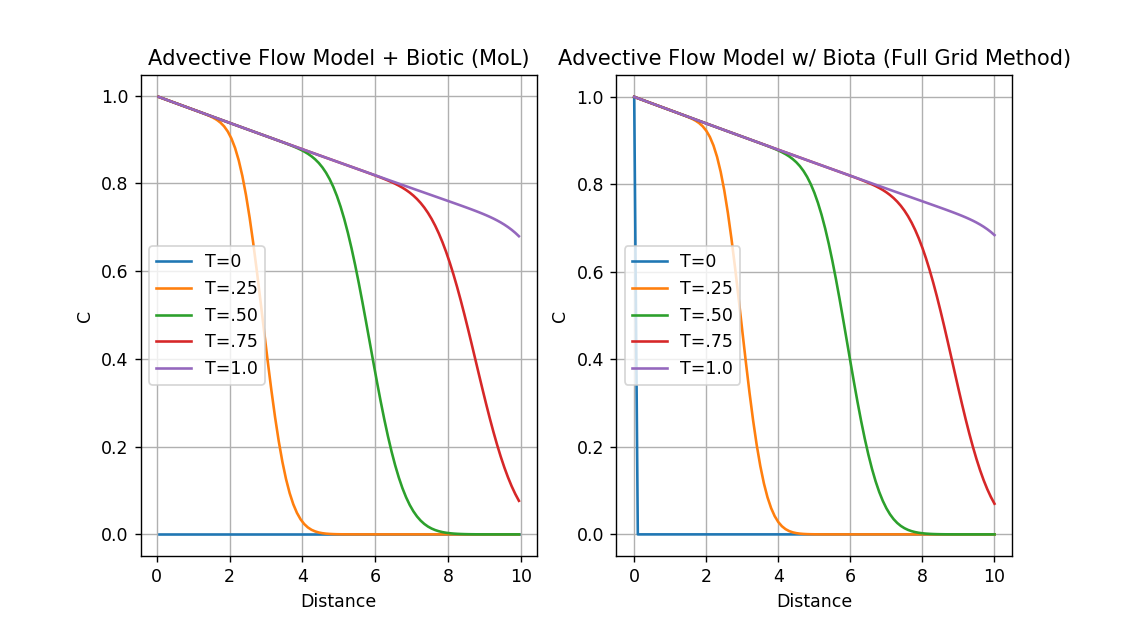

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# first, make the grid
C = np.zeros((nrows,ncols))

# set left hand boundary to 1 mg/L C.  Note that initial conditions are set to zero already
C[:,0] = 1.0
# alternative - zero, except spike throughout day 2
#day2Start = int(2/dt)
#day2End = int(3/dt)
#C[:,0] = 0
#C[day2Start:day2End,0] = Cin;

# set biota level
B = 0.1

# everything set up, solve the model by looping through cols, then rows, to solve interior nodes
for j in range(0, nrows-1):   # each row is a time level
    for i in range(1,ncols):    # each col is a location in space. We don't set column 0 because it is a boundary condition
        C[j+1,i] = C[j,i] -  (flowrate*dt/dx)*(C[j,i] - C[j,i-1]) - (mumax*(C[j,i]/(Kc + C[j,i]))*B/Ybc)*dt

# simulation complete, plot results
fig = plt.figure(figsize=(9,5))

# add MoL results
plt.subplot(121)
plt.plot(distsMoL,YB[0,:], label="T=0")
plt.plot(distsMoL,YB[int(t/4),:], label="T=.25")
plt.plot(distsMoL,YB[int(t/2),:], label="T=.50")
plt.plot(distsMoL,YB[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,YB[-1,:], label="T=1.0")
plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model + Biotic (MoL)')

plt.subplot(122)
plt.plot(distsGrid,C[0,:], label="T=0")
plt.plot(distsGrid,C[int(t/4),:], label="T=.25")
plt.plot(distsGrid,C[int(t/2),:], label="T=.50")
plt.plot(distsGrid,C[int(3*t/4),:], label="T=.75")
plt.plot(distsGrid,C[-1,:], label="T=1.0")

plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.ylabel('C')
plt.title( 'Advective Flow Model w/ Biota (Full Grid Method)')

plt.show()

<hr><a id='ar2_mol'></a><div style='text-align:right;width=100%'><a href='#top'>top</a></div>

## Advection/Reaction - Two Variable System

In this problem, we extend the Method of Lines to a two state variable system, by adding a dynamic biological component to the system above.  Our governing equations are:


$\large \frac{dC}{dt} = -f \frac{dC}{dx} - \mu_{max} \frac{C}{K_c + C} B Y_{cb} $

$\large \frac{dB}{dt} = -f \frac{dB}{dx} + \mu_{max} \frac{C}{K_c + C} B   $

Model parameters are defined as before.  Our solution procedure is similar to as before, but we have twice as many state variables to track - two per descretized compartment, so our model function will have to accomodate that.


In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# model function.  Note that we will have two state variables for each spatial compartment.
# State variables are packed first with all the C's for each compartment, followed by B's
def AdvectiveFlowWithDynamicBio_MoL( Y,t ):
    svCount = len(Y)    # Note: this is twice the number of compartments
    bins = int(svCount/2)
    
    dY_dt = np.zeros( svCount )     # allocate array for derivative values to return 
    
    f = 1          # flowrate, m3/day
    Cin = 1.0      # Constant left hand (upstream) boundary condition, mg/L = g/m3
    #Cin = 0
    #if ( t >= 2 and t < 3 ):
    #    Cin = 1.0
    
    Bin = 0.1

    C = Y[0] 
    B = Y[bins]
    # First, solve C,B left-hand compartment (next to boundary coundition)
    dY_dt[0] = -f*(C-Cin)/dx  - (mumax*B*C/(Kc+C))/Ybc     # set left hand side derivative based on boundary condition
    dY_dt[bins] = -f*(B-Bin)/dx + mumax*B*C/(Kc+C)     # set left hand side derivative based on boundary condition

    # Then solve rest of the compartments, left to right
    for i in range(1, bins):     # Note that we start the loop at 1, not 0, since we've already set LHS boundary condition
        Ci = Y[i]
        Cim1 = Y[i-1]
        Bi = Y[bins+i]
        Bim1 = Y[bins+i-1]
        
        # first, do dC/dt
        dY_dt[i] = -f*(Ci-Cim1)/dx - (mumax*Bi*Ci/(Kc+Ci))/Ybc
        
        # then dB/dt
        dY_dt[bins+i] = -f*(Bi-Bin)/dx + mumax*Bi*Ci/(Kc+Ci)
    
    return dY_dt

# convenience function to run the model
def RunTheModelWithDynamicBiota():
    # allocate and set initial conditions to zero across space 
    initConditions= np.zeros(n*2)
    
    # run simulation by integrating descretized compartments
    YB2 = odeint( AdvectiveFlowWithDynamicBio_MoL, initConditions, times )
    return YB2


YDB = RunTheModelWithDynamicBiota()

# generate two plots    
fig = plt.figure(figsize=(10,5))

plt.subplot(131)
plt.plot(distsMoL,YB[0,:], label="T=0")
plt.plot(distsMoL,YB[int(t/4),:], label="T=.25")
plt.plot(distsMoL,YB[int(t/2),:], label="T=.50")
plt.plot(distsMoL,YB[int(3*t/4),:], label="T=.75")
plt.plot(distsMoL,YB[-1,:], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('C')
plt.grid()
plt.title( 'C (Constant Biota)')

plt.subplot(132)
plt.plot(distsMoL,YDB[0,:n], label="T=0")
plt.plot(distsMoL,YDB[int(t/4),:n], label="T=.25")
plt.plot(distsMoL,YDB[int(t/2),:n], label="T=.50")
plt.plot(distsMoL,YDB[int(3*t/4),:n], label="T=.75")
plt.plot(distsMoL,YDB[-1,:n], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('C')
plt.grid()
plt.title( 'C (Dynamic Biota)')

plt.subplot(133)
#p"lt.plot(distsMoL,YDB[0,n:], label="T=0")
plt.plot(distsMoL,YDB[int(t/4),n:], label="T=.25")
plt.plot(distsMoL,YDB[int(t/2),n:], label="T=.50")
plt.plot(distsMoL,YDB[int(3*t/4),n:], label="T=.75")
plt.plot(distsMoL,YDB[-1,n:], label="T=1.0")
plt.legend()
plt.xlabel('Distance')
plt.ylabel('B')
plt.grid()
plt.title( 'Biota (Dynamic Biota)')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>